# Using SPAM algorithm to generate LDCs

SPAM, which stands for Synthetic-Photometry/Atmosphere-Model, is an algorith to generate limb darkening coefficients from synthetic exoplanet transit photometry using model stellar atmospheres. The model originally presented in [Howarth (2011)](https://academic.oup.com/mnras/article/418/2/1165/1071889) and modified in [Espinoza & Jordan (2015)](https://academic.oup.com/mnras/article/450/2/1879/985166); we, here, used the modified version of the same code from [Espinoza & Jordan (2015)](https://academic.oup.com/mnras/article/450/2/1879/985166), named as MC-SPAM (stands for Monte-Carlo SPAM algorithm). The main difference between both versions in that the later deals with the uncertainties in the transit parameters.

A prime motivation behind the algorithm is to provide a proper set of limb darkening coefficients which can be used in comparison with the ones derived from the transit photometry. Most of the tables (see, [Claret 2017](https://www.aanda.org/articles/aa/full_html/2017/04/aa29705-16/aa29705-16.html) for example) that provide computed set of the limb-darkening coefficients fit intensity profile from model stellar atmospheres to the limb-darkening laws to compute the LDCs. Or there are many other methods as well, however, all of them primarily use intensity profile to find LDCs (see, [Howarth 2011](https://academic.oup.com/mnras/article/418/2/1165/1071889)). This method to determine the limb-darkening coefficients is inherently different from the one which fits the exoplanet transit lightcurves to obtain LDCs. It is thus inevitable to get different sets of LDCs from both of these methods, hence, it is not advisable to compare both sets of LDCs directly with each other --- they would show a discrepancy between them. [Howarth (2011)](https://academic.oup.com/mnras/article/418/2/1165/1071889) proposed an elegant way forward with SPAM algorithm.

The basic idea is simple: the intensity profile of a given star can be used to compute a synthetic exoplanet transit lightcurve using the parameters of a given exoplanet. An another transit lightcurve model is now produced with limb-darkening coefficients as free parameters --- this model is then fitted to the sythetic transit lightcurve to yield the LDCs while fitting for the transit parameters as well.

One of the drawbacks of this algorithm is its ignorance towards the uncertainties in transit parameters. [Espinoza & Jordan (2015)](https://academic.oup.com/mnras/article/450/2/1879/985166) proposed a new [MC-SPAM](https://github.com/nespinoza/mc-spam) (Monte-Carlo SPAM) algorithm to overcome this shortcoming. Furthermore, in this version of SPAM, the transit parameters are fixed in the last step.

In this notebook, we demonstrate the MC-SPAM algorithm and its usage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from scipy.optimize import curve_fit as cft
from scipy.optimize import minimize as mz
from scipy.optimize import leastsq as lsq

We now use $\texttt{batman}$ package to define a transit model, which takes stellar and planetary transit parameters and gives flux at each phase.

In [2]:
def transit(time, t0, per, rp, a, b, ecc, w, u, law):
    para = batman.TransitParams()
    para.t0 = t0
    para.per = per
    para.rp = rp
    para.a = a
    cosi = b/a
    in1 = 180*np.arccos(cosi)/np.pi
    para.inc = in1
    para.ecc = ecc
    para.w = w
    para.u = u
    para.limb_dark = law
    m = batman.TransitModel(para, time)
    fl = m.light_curve(para)
    return fl

We now demonstrate the usage of this function with planetary parameters of WASP-62 system:
- $P = 4.41193789 \pm 0.000000315$
- $R_p/R_* = 0.11108 \pm 0.00015$
- $a/R_* = 9.719 \pm 0.032$
- $b = 0.228 \pm 0.015$
- $ecc = 0.0$
- $\omega = 90^\circ$
- $u_{non-linear} = [0.5050, 0.2916, -0.1613, 0.0089]$
- $u_{juliet} = [0.302 \pm 0.013, 0.134 \pm 0.027]$

We can compute limiting limb-darkening coefficients (see, [Espinoza & Jordan 2015](https://academic.oup.com/mnras/article/450/2/1879/985166) for details), for [Claret (2017)](https://www.aanda.org/articles/aa/full_html/2017/04/aa29705-16/aa29705-16.html) ATLAS coefficients.

- $u_{limiting} = [0.24189659047619047, 0.3079834603174603]$

Below, we plot our synthetic lightcurve using the function defined above (using non-linear LDCs),

Text(0, 0.5, 'Normalized flux')

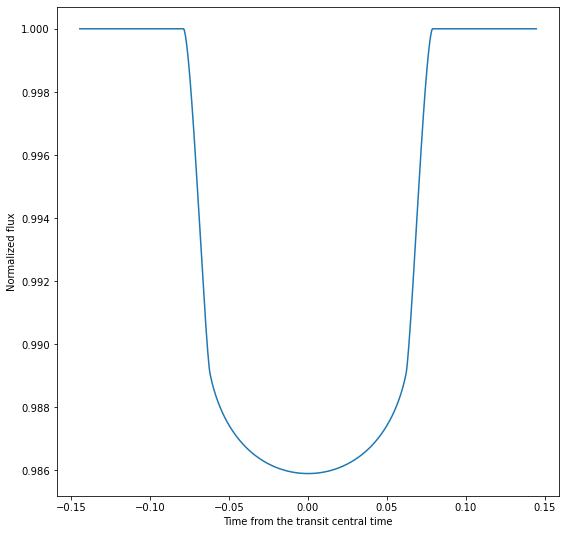

In [11]:
time = np.linspace(-4.41193789/(9.719*np.pi), 4.41193789/(9.719*np.pi), 1000)
flux = transit(time, 0., 4.41193789, 0.11108, 9.719, 0.228, 0., 90., [0.5050, 0.2916, -0.1613, 0.0089], "nonlinear")

plt.figure(figsize=(9,9))
plt.plot(time, flux)
plt.xlabel('Time from the transit central time')
plt.ylabel('Normalized flux')